# Experiments with Synthetic Data

This notebook shows how to reproduce the experiments in *Approximate Inference for Constructing Astronomical Catalogs from Images* using the [Celeste.jl](https://github.com/jeff-regier/Celeste.jl) package and Julia 0.6.4. To install Celeste, run
```
Pkg.update()
Pkg.add("Celeste")
```

In [1]:
Pkg.status("Celeste")

 - Celeste                       0.4.0+             reproducibility (dirty)


In [2]:
import Celeste: AccuracyBenchmark, SDSSIO, Synthetic, ParallelRun
using DataFrames
import PyPlot

## 1. Visually check that synthetic data resembles real data

In [3]:
coadd_catalog = AccuracyBenchmark.load_coadd_catalog(AccuracyBenchmark.COADD_CATALOG_FITS)

# filter the coadd catalog -- these columns can't be missing
no_na_cols = :flux_r_nmgy, :color_ug, :color_gr, :color_ri, :color_iz
for col in no_na_cols
    coadd_catalog = coadd_catalog[.!ismissing.(coadd_catalog[col]), :]
end

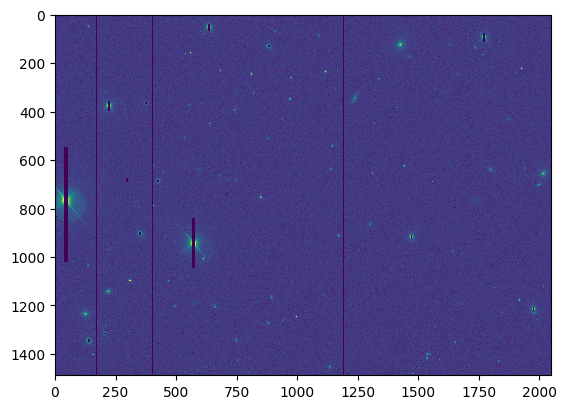

PyObject <matplotlib.image.AxesImage object at 0x7f20417187f0>

In [4]:
# load SDSS images
dataset = SDSSIO.SDSSDataSet(AccuracyBenchmark.SDSS_DATA_DIR)
sdss_images = SDSSIO.load_field_images(dataset, AccuracyBenchmark.STRIPE82_RCF);
plot_data = AccuracyBenchmark.plot_image(sdss_images[3]);
PyPlot.imshow(plot_data)

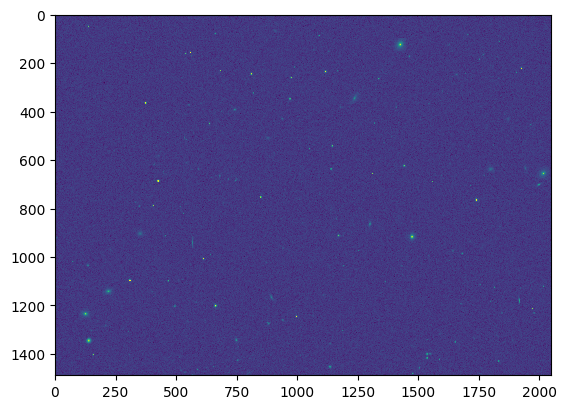

PyObject <matplotlib.image.AxesImage object at 0x7f2048d8f5c0>

In [5]:
# generate images by conditioning on the coadd catalog
conditional_images = deepcopy(sdss_images)
catalog_entries = [
    AccuracyBenchmark.make_catalog_entry(row)
        for row in eachrow(coadd_catalog)]
Synthetic.gen_images!(conditional_images, catalog_entries)
plot_data = AccuracyBenchmark.plot_image(conditional_images[3]);
PyPlot.imshow(plot_data)

## 2. Draw a catalog from the prior

In [6]:
prior_catalog = AccuracyBenchmark.generate_catalog_from_celeste_prior(500, 12345)
head(prior_catalog)

,ra,dec,is_star,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg
1,0.535903,0.627301,false,7.5945,-0.172541,1.09821,0.643075,-0.381725,0.272905,0.096291,1.84125,166.017
2,0.544344,0.550995,false,0.989773,-4.28371,1.37187,0.496161,1.30101,0.720652,0.655117,6.1787,50.211
3,0.455679,0.442466,true,8.91759,3.31271,1.22492,0.358178,0.269155,missing,missing,missing,missing
4,0.469984,0.473291,false,4.05966,0.597365,-0.00497866,0.288615,0.598756,0.386987,0.463955,10.2972,87.5557
5,0.492634,0.452557,true,5.92552,0.72135,2.00172,1.53289,1.0992,missing,missing,missing,missing
6,0.524173,0.563189,false,0.217006,-1.08506,1.64567,0.811115,-0.0872554,0.209362,0.503684,7.22285,97.8714


## 3. Draw an image set conditional on the sampled catalog

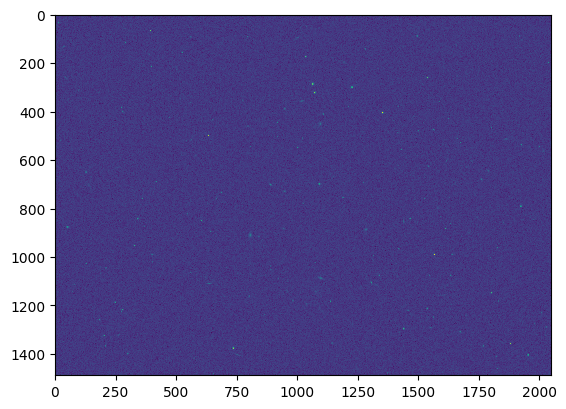

PyObject <matplotlib.image.AxesImage object at 0x7f2048bfb4e0>

In [7]:
# generate images based on the prior catalog
prior_images = deepcopy(sdss_images)
catalog_entries = [
    AccuracyBenchmark.make_catalog_entry(row)
        for row in eachrow(prior_catalog)]
Synthetic.gen_images!(prior_images, catalog_entries)
plot_data = AccuracyBenchmark.plot_image(prior_images[3]);
PyPlot.imshow(plot_data)

## 4. Run variational inference (VI) on the image set

The next block of code takes about 30 minutes single threaded. To enable more threads, before launching Jupyter, set two environment variables:
```
export OMP_NUM_THREADS=1
export JULIA_NUM_THREADS=4
```

In [8]:
box = ParallelRun.BoundingBox(-1000.0, 1000.0, -1000.0, 1000.0)
vi_results = ParallelRun.infer_box(prior_images, box; method = :single_vi);
celeste_catalog = AccuracyBenchmark.celeste_to_df(vi_results);

[1]<1> INFO: processing box -1000.0, 1000.0, -1000.0, 1000.0 with 4 threads
[1]<1> INFO: #1 at (0.4462509311342979, 0.598775974993399): 21.217022319 secs
[1]<3> INFO: #3 at (0.447064515380352, 0.5454567403117805): 21.323841421 secs
[1]<2> INFO: #4 at (0.4470447140950976, 0.5271336447728052): 21.777263887 secs
[1]<4> INFO: #2 at (0.44659298178348517, 0.412018134304243): 21.840257324 secs
[1]<3> INFO: #6 at (0.44894263343603436, 0.5216007961964171): 0.673457146 secs
[1]<3> INFO: #9 at (0.45136886471471577, 0.5775420535482041): 0.680784356 secs
[1]<1> INFO: #5 at (0.44829958984585055, 0.5242487702805364): 1.582285277 secs
[1]<4> INFO: #8 at (0.4503166846101742, 0.45373680806470607): 1.061058839 secs
[1]<2> INFO: #7 at (0.4492647749772267, 0.4423798925178572): 1.091019952 secs
[1]<3> INFO: #10 at (0.45290039617969957, 0.49788573493673904): 1.047883823 secs
[1]<4> INFO: #12 at (0.45300974978013053, 0.4720246853118094): 1.031456608 secs
[1]<1> INFO: #11 at (0.45268394527781725, 0.57460837652

## 5. Run MCMC on the image set

MCMC is parallelized differently (using `pmap`), which requires running an exterior script to schedule a set of jobs.  For the MCMC SDSS Stripe2 experiment script to run, we need a few files to be saved (based on the synthetic catalog and the image pixels generated above).  The following commands will reproduce our experiments

1. Create ground truth files (repeats code above)
  ```
$ cd Celeste.jl/benchmark/accuracy
$ julia write_ground_truth_catalog_csv.jl prior
$ julia generate_synthetic_field.jl prior_<hash>.csv
  ``` 
  which will create the following files in `Celeste.jl/benchmark/accuracy/output`:
      * `prior_<hash>.csv` : synthetic catalog drawn from the prior
      * `prior_<hash>_synthetic_<hash>.jld` : synthetic image of sources
      
2. Run the AIS-MCMC code on each source
  ```
$ cd Celeste.jl/experiments/mcmc_scripts
$ ./run_synthetic_shards.sh
  ```
  which will schedule jobs for each set of sources and store samples in directory `ais-output-synthetic`.
 
3. Score results 
```
julia score_mcmc_results.jl \
    --ais-output ais-output-synthetic \
    --output-dir synthetic-results \
    --truth-csv  ~/Proj/Celeste.jl/benchmark/accuracy/output/prior_<hash>.csv
    --vb-csv  ~/Proj/Celeste.jl/benchmark/accuracy/output/prior_<hash>_synthetic_<hash>_predictions_<hash>.csv
```
  which saves a bunch of `csv` files to `experiments/mcmc_scripts/synthetic-results/` needed to reproduce plots (including the prediction score and uncertainty score dataframes that mirror the results below). 

## 6. Score predictions

In [9]:
prediction_dfs = [celeste_catalog,]
scores = AccuracyBenchmark.score_predictions(prior_catalog, prediction_dfs)

,N,first,field
1,124,0.0483871,missed_stars
2,305,0.0262295,missed_galaxies
3,429,0.107366,position
4,429,0.124774,flux_r_mag
5,429,0.349698,flux_r_nmgy
6,44,5.25679,gal_angle_deg
7,80,0.250228,gal_frac_dev
8,80,0.0991387,gal_axis_ratio
9,80,0.551287,gal_radius_px
10,429,0.372569,color_ug


## 7. Score uncertainty

In [10]:
uncertainty_df = AccuracyBenchmark.get_uncertainty_df(prior_catalog, celeste_catalog)
scores = AccuracyBenchmark.score_uncertainty(uncertainty_df)

,field,within_half_sd,within_1_sd,within_2_sd,within_3_sd
1,log_flux_r_nmgy,0.15814,0.316279,0.497674,0.646512
2,color_ug,0.265116,0.502326,0.77907,0.9
3,color_gr,0.24186,0.455814,0.737209,0.853488
4,color_ri,0.22093,0.44186,0.690698,0.830233
5,color_iz,0.353488,0.574419,0.827907,0.927907


In [ ]:
scores_mc = CSV.read("mcmc_scripts/synthetic-results/uscore_mc.csv")